# Reddit Comments from May 2015

This dataset contains every publicly available Reddit comment for the month of May, 2015. Approximately 37 million comments were made by 2.7 million unique authors, stored in a ~15 GB compressed file.

In [1]:
from pyspark.sql import SparkSession

hdfs_path = "hdfs://namenode:9000/user/spark/reddit_comments/"
spark_master = "spark://spark-master:7077"

spark = (
    SparkSession.builder.master(spark_master)
    .appName("Reddit word analysis")
    .getOrCreate()
)

df = (
        spark.read.format("parquet")
        .option("header", "true")
        .load(hdfs_path)
    )

df_copy = df

df_copy = df[["body", "score", "subreddit"]] # Drop any tables except these three
df_copy.sort("score", ascending=False).show(10)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 15:51:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+-----+---------+
|                body|score|subreddit|
+--------------------+-----+---------+
|Then you got your...| 6761|AskReddit|
|Thanks man and al...| 5849|AskReddit|
|We had an office ...| 5776|AskReddit|
|OP are you alrigh...| 5767|AskReddit|
|So she's pregnant...| 5762|AskReddit|
|Forum based websi...| 5710|AskReddit|
|It would be the i...| 5699|AskReddit|
|         ¯\\_(ツ)_/¯| 5673|AskReddit|
|HEY! THAT'S ME!!!...| 5642|    funny|
|Being fucking lat...| 5570|AskReddit|
+--------------------+-----+---------+
only showing top 10 rows



### Filter out non-latin characters, spaces, and null strings. Create new dataframe containing list of words in a given sentence (body)

In [2]:
from pyspark.sql.functions import explode, split, lower, regexp_replace
from pyspark.sql.functions import col

df_copy = df_copy.filter(col("body") != "[deleted]")
df_copy = df_copy.filter(col("body") != "[removed]")
df_copy = df_copy.filter(col("body").isNotNull() & (col("body") != ""))

latin_pattern = "[^a-zA-Z\s]"

words_df = df_copy.select(explode(split(lower(regexp_replace(col("body"), latin_pattern, ' ')), "\s+")).alias("word"))
words_df = words_df.filter(col("word") != "")

### Fetch corpus of commonly used stopwords in english language and filter them out of any body of text

In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
words_filtered_df = words_df.filter(~col("word").isin(stop_words))

### Count the occurences of each word

In [5]:
word_counts = words_filtered_df.groupBy("word").count()

### Retrieve top 1000 words

In [6]:
top_1000_words = word_counts.orderBy("count", ascending=False).limit(1000).collect()
word_freq = {word["word"]: word["count"] for word in top_1000_words}

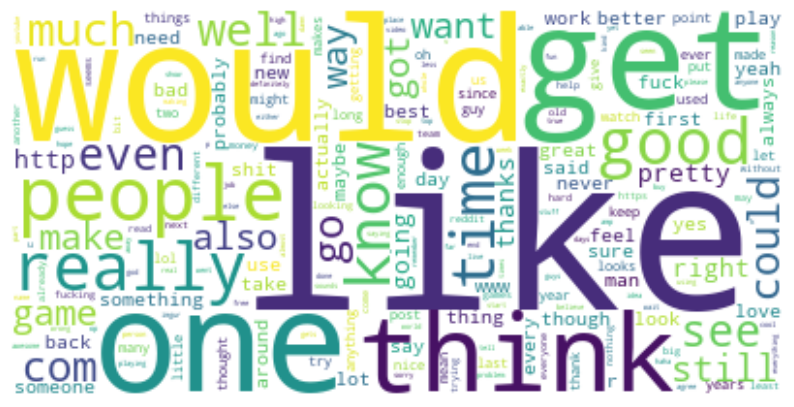

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cloud = WordCloud(background_color="white", max_words=1000)
cloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 8))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()